In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

In [4]:
import platform 

platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2023/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on Code Ocean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2023/"

manifest_path = os.path.join(data_root,'allen-brain-observatory/visual-coding-neuropixels/ecephys-cache/manifest.json') 
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path) #creates a cache object
sessions = cache.get_session_table() #session_table is a pandas dataframe object that contains metadata about all sessions in the cache
sessions.head() #show the first 5 rows of the dataframe object 

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
721123822,2019-10-03T00:00:00Z,707296982,brain_observatory_1.1,125.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,444,2229,6,"[MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ..."
732592105,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt,824,1847,5,"[grey, VISpm, nan, VISp, VISl, VISal, VISrl]"
737581020,2019-10-03T00:00:00Z,718643567,brain_observatory_1.1,108.0,M,wt/wt,568,2218,6,"[grey, VISmma, nan, VISpm, VISp, VISl, VISrl]"


In [5]:
session_id = 715093703 #import a session id of interest
session = cache.get_session_data(session_id) #creates a session object


In [6]:
presentations = session.get_stimulus_table('drifting_gratings') #creates a stimulus table object for drifting gratings
#print unique values of the stimulus table
print(presentations['orientation'].unique())

#what kind of type are each item in the unique values?
print(type(presentations['orientation'].unique()[6]))

#remove the null value from the unique values
presentations = presentations[presentations['orientation'] != presentations['orientation'].unique()[6]]
presentations['orientation'].unique()

[315.0 90.0 225.0 135.0 0.0 270.0 'null' 180.0 45.0]
<class 'str'>


array([315.0, 90.0, 225.0, 135.0, 0.0, 270.0, 180.0, 45.0], dtype=object)

Text(0.5, 1.0, 'peristimulus time histograms for VISp units on drifting gratings presentations')

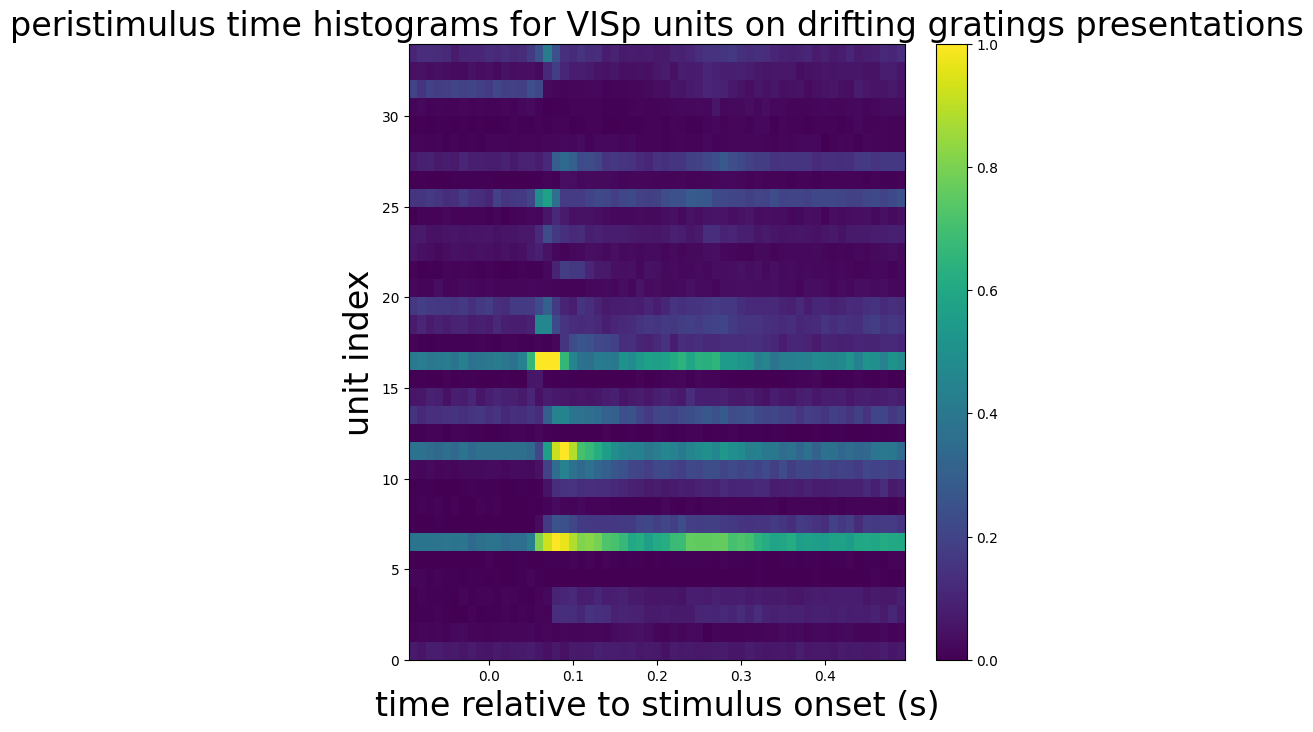

In [7]:
session_id = 715093703 #import a session id of interest
session = cache.get_session_data(session_id) #creates a session object

presentations = session.get_stimulus_table('drifting_gratings') #creates a stimulus table object for drifting gratings
presentations = presentations[presentations.orientation != 'null'] #removes the null orientation presentations
region = "VISp" #specify the region of interest

#units = session.units[session.units["ecephys_structure_acronym"] == region] #creates a units table object for the region of interest

time_step = 0.01 #in sessions 
pre_stim_window = -0.1 #in seconds
window_duration = 0.5 #in seconds
time_bins = np.arange(pre_stim_window, window_duration + time_step, time_step) #create an array of time bins for the window of interest 

spikes = session.presentationwise_spike_counts(
    stimulus_presentation_ids = presentations.index.values, 
    bin_edges = time_bins, 
    unit_ids = session.units.query('snr > 2.5 & isi_violations < 0.5 & amplitude_cutoff < 0.1 & presence_ratio > 0.9 & ecephys_structure_acronym == @region').index.values
    )

# grab distinct orientations (directions)
unique_orientations = presentations.orientation.unique()
unique_orientations.sort() 

### calculate means_spikes 

mean_spikes = spikes.mean(dim="stimulus_presentation_id")

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.pcolormesh(
    mean_spikes["time_relative_to_stimulus_onset"], # x axis 
    np.arange(mean_spikes["unit_id"].size), #arange for 
    mean_spikes.T, #transpose the matrix so that the units are on the y axis and time is on the x axis
    vmin=0,
    vmax=1
)
fig.colorbar(im, ax=ax)
ax.set_ylabel("unit index", fontsize=24)
ax.set_xlabel("time relative to stimulus onset (s)", fontsize=24)
ax.set_title("peristimulus time histograms for VISp units on drifting gratings presentations", fontsize=24)

In [8]:
def get_spike_counts(session_id, region, window_duration):
    
    #to-do: 
        #update drifting_gratings can be changed to other stimuli for scaling purposes
    
    #input: session id, region of interest, window duration
        #session id: int, specific session id of interest
        #region of interest: string, specific region of interest
        #window duration: float, duration of the window of interest in seconds
        
    #output: spike counts for the region of interest in xarray format where the dimensions are unit, time, and stimulus presentation id in that order
    
    #example: spikes = get_spike_counts(715093703, "VISp", 0.5) 
    
    
    session = cache.get_session_data(session_id) #creates a session object  
    presentations = session.get_stimulus_table('drifting_gratings') #creates a stimulus table object for drifting gratings,  
    
    presentations = presentations[presentations.orientation != 'null'] #remove the null 
    time_step = 0.001 #in seconds 
    pre_stim_window = -0.1 #in seconds
    
    time_bins = np.arange(pre_stim_window, window_duration + time_step, time_step) #create an array of time bins for the window of interest 
    
    #apply the .presentationwise_spike_counts method to the session object to get the spike counts for the region of interest 
    
    spikes = session.presentationwise_spike_counts(
        stimulus_presentation_ids = presentations.index.values, 
        bin_edges = time_bins, 
        unit_ids = session.units.query('snr > 2.5 & isi_violations < 0.5 & amplitude_cutoff < 0.1 & presence_ratio > 0.9 & ecephys_structure_acronym == @region').index.values
        )
    return spikes


#test the function
spikes = get_spike_counts(715093703, "VISp", 2)

In [ ]:
spikes

In [ ]:
#what are the unique unit_ids? in the spikes xarray
spikes.unit_id.values
spikes.time_relative_to_stimulus_onset.values
print(spikes.stimulus_presentation_id.values)


In [ ]:
pre_stimulus_start = -0.05
pre_stimulus_end = 0
post_stimulus_start = 0
post_stimulus_end = 0.1

df_list = [] # define an empty list to store the dictionaries

for unit_id in spikes.unit_id.values.tolist():
    for orientation in unique_orientations.tolist():
        
        trial_ids = presentations[presentations.orientation == orientation].index.values.tolist() #get the trial ids for the specific orientation
        print(trial_ids)
        #keep track and print the the total number of trials for each orientation
        print("number of trials for orientation " + str(orientation) + " is " + str(len(trial_ids)))
        
        # select the pre- and post-stimulus onset spikes for the specific orientation
        pre_spikes = spikes.loc[{'unit_id': unit_id, 'stimulus_presentation_id': trial_ids, 'time_relative_to_stimulus_onset': slice(pre_stimulus_start, pre_stimulus_end)}]
        post_spikes = spikes.loc[{'unit_id': unit_id, 'stimulus_presentation_id': trial_ids, 'time_relative_to_stimulus_onset': slice(post_stimulus_start, post_stimulus_end)}]
        
        # calculate the mean pre- and post-stimulus onset spikes for the specific orientation
        pre_spikes_mean = pre_spikes.mean(dim='stimulus_presentation_id')
        post_spikes_mean = post_spikes.mean(dim='stimulus_presentation_id')
        
        # calculate the number of trials for the specific orientation
        num_trials = len(trial_ids)
        
        # normalize the mean pre- and post-stimulus onset spikes based on the number of trials
        pre_spikes_mean_norm = pre_spikes_mean.values / num_trials
        post_spikes_mean_norm = post_spikes_mean.values / num_trials
        
        #store the pre and post stimulus in a dictionary first, make the row index the trial id
        df_dict = {'unit_id': unit_id, 'trial_id': trial_ids, 'orientation': orientation, 'pre_stimulus_mean': pre_spikes_mean_norm, 'post_stimulus_mean': post_spikes_mean_norm}
        
        #append the dictionary to the list
        df_list.append(df_dict)        

        
        #print the pre and post stimulus onset spikes for each orientation for each unit
        print("pre stimulus onset spikes for orientation " + str(orientation) + " for unit " + str(unit_id) + " is " + str(pre_spikes_mean_norm))
        print("post stimulus onset spikes for orientation " + str(orientation) + " for unit " + str(unit_id) + " is " + str(post_spikes_mean_norm))
        
        #print the pre and post mean for each orientation for each unit
        print("pre stimulus onset mean for orientation " + str(orientation) + " for unit " + str(unit_id) + " is " + str(pre_spikes_mean.values))
        print("post stimulus onset mean for orientation " + str(orientation) + " for unit " + str(unit_id) + " is " + str(post_spikes_mean.values))
        

In [ ]:
pre_stimulus_start = -0.05
pre_stimulus_end = 0
post_stimulus_start = 0
post_stimulus_end = 0.1

df_list = [] # define an empty list to store the dictionaries

for unit_id in spikes.unit_id.values.tolist():
    for orientation in unique_orientations.tolist():
        
        trial_ids = presentations[presentations.orientation == orientation].index.values.tolist() #get the trial ids for the specific orientation
        print(trial_ids)
        #keep track and print the the total number of trials for each orientation
        print("number of trials for orientation " + str(orientation) + " is " + str(len(trial_ids)))
        
        # select the pre- and post-stimulus onset spikes for the specific orientation
        pre_spikes = spikes.loc[{'unit_id': unit_id, 'stimulus_presentation_id': trial_ids, 'time_relative_to_stimulus_onset': slice(pre_stimulus_start, pre_stimulus_end)}]
        post_spikes = spikes.loc[{'unit_id': unit_id, 'stimulus_presentation_id': trial_ids, 'time_relative_to_stimulus_onset': slice(post_stimulus_start, post_stimulus_end)}]
        
        # calculate the mean pre- and post-stimulus onset spikes for the specific orientation
        pre_spikes_mean = pre_spikes.mean(dim='stimulus_presentation_id')
        post_spikes_mean = post_spikes.mean(dim='stimulus_presentation_id')
        
        #store the pre and post stimulus in a dictionary first, make the row index the trial id
        df_dict = {'unit_id': unit_id, 'trial_id': trial_ids, 'orientation': orientation, 'pre_stimulus_mean': pre_spikes_mean.values, 'post_stimulus_mean': post_spikes_mean.values}
        
        #append the dictionary to the list
        df_list.append(df_dict)        

        
        #print the pre and post stimulus onset spikes for each orientation 
        print("pre stimulus onset spikes for orientation " + str(orientation) + " is " + str(pre_spikes_mean.values))
        print("post stimulus onset spikes for orientation " + str(orientation) + " is " + str(post_spikes_mean.values))

In [ ]:
#user input parameters 
pre = -0.05
post = 0.1

#creating a mask for using np.where 
pre_indices = np.where((spikes.time_relative_to_stimulus_onset.values >= pre) & (spikes.time_relative_to_stimulus_onset.values <0))[0] #np.where returns a list with two elements and only need first 
post_indices = np.where((spikes.time_relative_to_stimulus_onset.values >= 0 ) & (spikes.time_relative_to_stimulus_onset.values < post))[0] #np.where returns a list with two elements and only need first 

pre_spikes = spikes.loc[:, spikes.time_relative_to_stimulus_onset.values[pre_indices], :] #select the pre stimulus onset spikes
post_spikes = spikes.loc[:, spikes.time_relative_to_stimulus_onset.values[post_indices], :] #select the post stimulus onset spikes

pre_spikes_sum = pre_spikes.sum(dim="time_relative_to_stimulus_onset") #sum the pre stimulus onset spikes
post_spikes_sum = post_spikes.sum(dim="time_relative_to_stimulus_onset") #sum the post stimulus onset spikes 


In [ ]:
#test the for loop on one unit_id
unit_id = 950930697
#create an empty list to store the dataframes
df_list = [[]]
for unit_id in spikes.unit_id.values:
    for orientation in unique_orientations: 
        trial_ids = presentations[presentations.orientation == orientation].index.values #get the trial ids for the specific orientation
        pre_stimulus_mean = pre_spikes_sum.loc[{'unit_id': unit_id, 'stimulus_presentation_id': trial_ids}].mean(dim="stimulus_presentation_id").values #calculate the mean pre stimulus onset spikes
        post_stimulus_mean = post_spikes_sum.loc[{'unit_id': unit_id, 'stimulus_presentation_id': trial_ids}].mean(dim="stimulus_presentation_id").values #calculate the mean post stimulus onset spikes 

In [ ]:
import pandas as pd

# initialize an empty list to store the dataframes for each orientation where columns are unit_id, orientation, pre_stimulus_mean, post_stimulus_mean when looping through each unit_id
df_list = []


for unit_id in spikes.unit_id.values.tolist():
    for orientation in unique_orientations.tolist():
        
        trial_ids = presentations[presentations.orientation == orientation].index.values.tolist() #get the trial ids for the specific orientation
        print(trial_ids)
        #keep track and print the the total number of trials for each orientation
        print("number of trials for orientation " + str(orientation) + " is " + str(len(trial_ids)))
        
        # calculate the mean pre- and post-stimulus onset spikes for the specific orientation
        pre_spikes_mean = spikes.loc[{'unit_id': unit_id, 'stimulus_presentation_id': trial_ids, 'time': slice(pre_stimulus_start, pre_stimulus_end)}].mean(dim='stimulus_presentation_id')
        post_spikes_mean = spikes.loc[{'unit_id': unit_id, 'stimulus_presentation_id': trial_ids, 'time': slice(post_stimulus_start, post_stimulus_end)}].mean(dim='stimulus_presentation_id')
        
        #store the pre and post stimulus in a dictionary first 
        df_dict = {'unit_id': unit_id, 'orientation': orientation, 'pre_stimulus_mean': pre_spikes_mean.values, 'post_stimulus_mean': post_spikes_mean.values}
        
        #print the pre and post stimulus onset spikes for each orientation 
        print("pre stimulus onset spikes for orientation " + str(orientation) + " is " + str(pre_spikes_mean.values))
        print("post stimulus onset spikes for orientation " + str(orientation) + " is " + str(post_spikes_mean.values))
        
        

In [ ]:
pre_stimulus_mean.shape

In [ ]:
#for each unit_id, for each unique orientaiton, calculate the mean pre and post and normalize based on the number of trials for each orientation
for unit_id in spikes.unit_id.values:
    for orientation in unique_orientations:
        
        trial_ids = presentations[presentations.orientation == orientation].index.values #get the trial ids for the specific orientation
        
        pre_stimulus_mean = pre_spikes_sum.loc[trial_ids, :, unit_id].mean() #calculate the mean pre stimulus onset spikes for the specific unit_id and orientation
        post_stimulus_mean = post_spikes_sum.loc[trial_ids, :, unit_id].mean() #calculate the mean post stimulus onset spikes for the specific unit_id and orientation
        
        #store the pre and post stimulus onset means in a dataframe
        df = pd.DataFrame({'unit_id': unit_id, 'orientation': orientation, 'pre_stimulus_mean': pre_stimulus_mean, 'post_stimulus_mean': post_stimulus_mean}, index=[0])
        
        #append the dataframe to a list
        df_list.append(df)

In [ ]:
session_id = 715093703 #import a session id of interest
session = cache.get_session_data(session_id) #creates a session object
session = cache.get_session_data(session_id) #creates a session object
presentations = session.get_stimulus_table('drifting_gratings') #creates a stimulus table object for drifting gratings,  


In [ ]:
unit_ids = session.units.query('snr > 2.5 & isi_violations < 0.5 & amplitude_cutoff < 0.1 & presence_ratio > 0.9 & ecephys_structure_acronym == @region').index.values.tolist()



In [ ]:
for i, unit_id in enumerate(unit_ids): #for each unit id in the list of unit ids
    for orientation in unique_orientations: #for each orientation
        trial_ids = presentations[presentation.orientation == orientation].index.values #get the trial ids for the specific orientation 
        


In [ ]:
#calulate the mean spike counts for each unit across the the first 500ms post stimulus onset and store the result in in pandas where the row index are the unique units and the columns are the unique orientations 
mean_spikes = spikes.mean(dim="stimulus_presentation_id")
mean_spikes = mean_spikes.sel(time_relative_to_stimulus_onset=slice(0, 0.5)) 
mean_spikes 

#calcuulate the mean -100ms to 0ms and 0ms to 500ms spike counts for each unit and store the result in a pandas dataframe where the row index are the unique units and the columns are the unique orientations
mean_spikes = spikes.mean(dim="stimulus_presentation_id")
#select the pre and post stimulus onset time bins and save them as variables
pre_stimulus = mean_spikes.sel(time_relative_to_stimulus_onset=slice(-0.1, 0)) #select the pre stimulus onset time bins 
post_stimulus = mean_spikes.sel(time_relative_to_stimulus_onset=slice(0, 0.5))



In [ ]:
presentations = presentations[presentations.orientation != 'null'] #remove the null 


#

In [ ]:
session_id = 715093703 #import a session id of interest
session = cache.get_session_data(session_id) #creates a session object
#unit_ids = session.units.query('snr > 2.5 & isi_violations < 0.5 & amplitude_cutoff < 0.1 & presence_ratio > 0.9 & ecephys_structure_acronym == @region').index.values

good_unit_table = session.units.query('snr > 2.5 & isi_violations < 0.5 & amplitude_cutoff < 0.1 & presence_ratio > 0.9 & ecephys_structure_acronym == @region') #creates a list of good units for the region of interest
good_unit_list = session.units.query('snr > 2.5 & isi_violations < 0.5 & amplitude_cutoff < 0.1 & presence_ratio > 0.9 & ecephys_structure_acronym == @region').index.values.tolist() #creates a list of good units for the region of interest

In [ ]:
#grab the first unit and isolate the waveform_duration 
unit_id = good_unit_list[0]
unit = session.units.loc[unit_id]
waveform_duration = unit.waveform_duration
waveform_duration

#do the above with pandas to create a column if the value is greater than 0.4 it receives the label RS and if it is less than 0.4 it receives the label FS
good_unit_table['cell_type'] = np.where(good_unit_table['waveform_duration'] > 0.4, 'RS', 'FS') #creates a new column in the good unit table that labels the units as RS or FS based on the waveform duration, 
#if the waveform duration is greater than 0.4 it is labeled as RS and if it is less than 0.4 it is labeled as FS

good_unit_table

#count the total number of FS and RS units in the good unit table

good_unit_table['cell_type'].value_counts()

#what are the column names in the good unit table?
print(good_unit_table.columns)





In [ ]:
presentations["temporal_frequency"].unique()

In [ ]:
def get_spikes_append_waveformlabels_2_unit_table(session_id, region):
     
     #input: session id, region of interest
        #session id: int, specific session id of interest
        #region of interest: string, specific region of interest
        
    #output: good unit table with the cell type column
    #example: good_unit_table = get_spikes_append_waveformlabels(715093703, "VISp")
    
    session = cache.get_session_data(session_id) #creates a session object
    good_unit_table = session.units.query('snr > 2.5 & isi_violations < 0.5 & amplitude_cutoff < 0.1 & presence_ratio > 0.9 & ecephys_structure_acronym == @region') #creates a list of good units for the region of interest
    good_unit_table['cell_type'] = np.where(good_unit_table['waveform_duration'] > 0.4, 'RS', 'FS') #creates a new column in the good unit table that labels the units as RS or FS based on the waveform duration,
    #if the waveform duration is greater than 0.4 it is labeled as RS and if it is less than 0.4 it is labeled as FS
    
    return good_unit_table

#test the function
good_unit_table = get_spikes_append_waveformlabels_2_unit_table(session_id, region)

In [ ]:
#print the the number of FS and RS units in the good unit table
print(good_unit_table['cell_type'].value_counts()) #print the number of FS and RS units in the good unit table

In [ ]:
def get_ecephyssession_units_object(session_id, region): 
    
    #input: session id, region of interest
        #session id: int, specific session id of interest
        #region of interest: string, specific region of interest
        
    #output: session object
    
    #example: test_session = get_ecephyssession_object(715093703, "VISp")
    
    session_units = cache.get_units.query(session_id) #creates a session object  
    
    passed_qc_unit_ids = session_units.query('snr > 2.5 & isi_violations < 0.5 & amplitude_cutoff < 0.1 & presence_ratio > 0.9 & ecephys_structure_acronym == @region').index.values.tolist() #creates a list of unit ids that passed qc
    
    
    return passed_qc_unit_ids


#test the function
test = get_ecephyssession_units_object(715093703, "VISp")
    
    

In [ ]:


plt.show()

In [ ]:
unit_ids = session.units.query('snr > 2.5 & isi_violations < 0.5 & amplitude_cutoff < 0.1 & presence_ratio > 0.9 & ecephys_structure_acronym == @region').index.values
# conver the unit_ids to a list of values
unit_ids = unit_ids.tolist()

In [ ]:
fig, ax = plt.subplots(len(unit_ids), 1, figsize=(10, 30))

for i, unit_id in enumerate(unit_ids):
    for orientation in unique_orientations: 
        trial_ids = presentations[presentations.orientation == orientation].index.values        
        data = spikes.loc[trial_ids, :, unit_id]
        mean = data.mean(dim="stimulus_presentation_id")
        ax[i].plot(data["time_relative_to_stimulus_onset"], mean, label=orientation)
    ax[i].legend()
    ax[i].set_xlabel("time relative to stimulus onset")
    ax[i].set_ylabel("spike count in bin")
    ax[i].set_title(f"unit {unit_id} mean spike counts by stimulus grating direction")

In [ ]:
all_areas = [] 

for index, row in sessions.iterrows(): 
    for a in row.ecephys_structure_acronyms: 
        if a not in all_areas: 
            all_areas.append(a)
            
print(all_areas)

In [ ]:
#provide the number of unique specimens in the session table
print('Number of unique specimens in the session table: ' + str(len(sessions.specimen_id.unique())))
#count the number of unique full_genotype values in the session table
print('Number of unique full_genotype values in the session table: ' + str(len(sessions.full_genotype.unique())))
#provide the number of unique session_type values in the session table
print(cache.get_all_session_types())
#for each unique full_genotype value, count the number of sessions with that value
print('Number of sessions with each unique full_genotype value:')
print(sessions.full_genotype.value_counts())

In [ ]:
# create a brain_observatory_type_sessions dataframe
brain_observatory_type_sessions = sessions[sessions["session_type"] == "brain_observatory_1.1"]

#for each unique full_genotype value, count the number of sessions with that value
print('Number of sessions with each unique full_genotype value:')
print(brain_observatory_type_sessions.full_genotype.value_counts())

In [ ]:

presentations = session.get_stimulus_table('drifting_gratings') #creates a stimulus table object for drifting gratings
presentations = presentations[presentations.orientation != 'null'] #removes the null orientation presentations
region = 'VISp'#specify the region of interest
units = session.units[session.units["ecephys_structure_acronym"] == region] #creates a units table object for the region of interest


time_step = 0.05 #in sessions 
pre_stim_window = -0.1 #in seconds
window_duration = 0.5 #in seconds
time_bins = np.arange(pre_stim_window, window_duration + time_step, time_step) #create an array of time bins for the window of interest 

#session.units.query("snr > 2.5 & isi_violations < 0.5 & amplitude_cutoff < 0.1 & presence_ratio > 0.9") #query the units table to find units that pass QC criteria which are stored as columns in the units table
# the QC criteria are: snr is greater than 2.5, isi_violations is less than 0.5, amplitude_cutoff is less than 0.1, and presence_ratio is greater than 0.9 

spikes = session.presentationwise_spike_counts(
    stimulus_presentation_ids = presentations.index.values, 
    bin_edges = time_bins, 
    unit_ids = session.units.query("snr > 2.5 & isi_violations < 0.5 & amplitude_cutoff < 0.1 & presence_ratio > 0.9 and ece ").index.values
    )


In [ ]:
session.units

In [ ]:
session.structurewise_unit_counts #gives the number of units in each brain area for a given session

In [ ]:
presentations = session.get_stimulus_table('drifting_gratings') #creates a stimulus table object for drifting gratings

presentations = presentations[presentations.orientation != 'null'] #removes the null orientation presentations

region = VISp' #specify the region of interest
time_step = 0.05 #in sessions 
pre_stim_window = -0.1 #in seconds
window_duration = 0.5 #in seconds
time_bins = np.arange(pre_stim_window, window_duration + time_step, time_step) #create an array of time bins for the window of interest 

#selects only VISp units 
units_good = session.units[session.units['ecephys_structure_acronym'] == region]

# use SDK to count spikes into bins 
spikes = session.presentationwise_spike_counts(
    stimulus_presentation_ids=presentations.index.values,
    bin_edges=time_bins, 
    unit_ids=units.index.values
)


In [ ]:
#store the unique id values of the sessions in the brain_observatory_type_sessions dataframe in a list 
session_ids = brain_observatory_type_sessions.index.values.tolist()

#session_ids is a list of session ids in the brain_observatory_type_sessions dataframe

print('Number of sessions in the brain_observatory_type_sessions dataframe: ' + str(len(session_ids)))


In [ ]:
#create a function that will take in session id and allow the user to access the meta data for that session 
def get_session_data(session_id):
    session_metadata = cache.get_session_data(session_id).metadata
    return session_metadata 

In [ ]:
specific_id = session_1.get('ecephys_session_id') #use the get method to access the value associated with the key 'ecephys_session_id'

#print the value associated with the key 'ecephys_session_id'
print('ecephys_session_id for the first index of session_1: ' + str(session_1.get('ecephys_session_id')))

In [ ]:
#using the specific session id, access the session data for that session 
session_1_data = cache.get_session_data(specific_id)

#how many units are there in the session table?
print('Number of units in the session table: ' + str(len(session_1_data.units)))

In [ ]:
dg = session_1_data.get_stimulus_table('drifting_gratings')
dg[dg.orientation == 90]

In [ ]:
#define regions of interest 
region_of_interest = ['VISp']; #visual cortex, primary, will be used for now and will be a list of strings 

#prepare the time bins for computing the PSTH 
time_step = 0.05 # in seconds, will be a user input later 
pre_time = -0.5 # in seconds, will be a user input later
time_bins = np.arange(pre_time, 1.5, time_step) #will be a user input later, pre_time is the start of the time bins, 1.5 is the end of the time bins, time_step is the step size between each time bin 

session_1_data.structurewise_unit_counts #this is a pandas dataframe object that contains the number of units in each brain area for the session

temporal_freqs = session_1_data.get_stimulus_table('drifting_gratings')['temporal_frequency'].unique()

In [ ]:
session_1_data.unit?

In [ ]:
presentations = session_1_data.get_stimulus_table(["drifting_gratings"]) #this is a pandas dataframe object that contains the stimulus table for drifting gratings
print(presentations['orientation'].unique()) #this prints the unique orientation values in the stimulus table for drifting gratings

presentations


def sort_orientation_and_temporal_freq(session_data): 
    #'sort_orientation_and_temporal_freq' will sort the stimulus table for drifting gratings by orientation and temporal frequency values
    
    #input: session_data, a session data object from the AllenSDK of a single session
    #output: a sorted stimulus table for drifting gratings
    
    #create a list of unique orientation values in the stimulus table
    presentations = session_data.get_stimulus_table('drifting_gratings')['orientation'].unique() 

    #create a list of unique temporal frequency values in the stimulus table
    temporal_freqs = session_data.get_stimulus_table('drifting_gratings')['temporal_frequency'].unique()
    
    #sort the dataframe for each unique combination of orientation and temporal frequency values
    for orientation in presentations: #iterate over each unique orientation value in the stimulus table
        for temporal_freq in temporal_freqs: #iterate over each unique temporal frequency value in the stimulus table 
    

In [ ]:
print(f'{session_1_data.units.shape[0]} units total') #print the number of units in the session table
units_with_very_high_snr = session_1_data.units[session_1_data.units['snr'] > 4] #create a dataframe of units with snr > 4
print(f'{units_with_very_high_snr.shape[0]} units have snr > 4') #print the number of units with snr > 4

#plot the distribution of snr values for all units in the session table 
plt.hist(session_1_data.units['snr'], bins=100)
plt.xlabel('snr')
plt.ylabel('number of units')
plt.title('Distribution of snr values for all units in the session table')
plt.show()

#test for bimodality of snr values in the session table
from scipy.stats import kstest
kstest(session_1_data.units['snr'], 'norm') #if the p-value is less than 0.05, then the distribution is not normal

#plot the distribution of snr values for units with snr > 4
plt.hist(units_with_very_high_snr['snr'], bins=100)
plt.xlabel('snr')
plt.ylabel('number of units')
plt.title('Distribution of snr values for units with snr > 4')
plt.show()

#test for bimodality of snr values for units with snr > 4 
kstest(units_with_very_high_snr['snr'], 'norm') #if the p-value is less than 0.05, then the distribution is not normal



In [ ]:
#create a function that will iterate over the session_ids list, access the session data for each session id, and store the snr values for each session 
# pandas dataframe 

def get_snr_values(session_ids):
    snr_values = pd.DataFrame(columns=['session_id', 'unit_id', 'snr']) #create an empty pandas dataframe with columns 'session_id', 'unit_id', and 'snr'
    
    for session_id in session_ids: #iterate over the session_ids list
        session_data = cache.get_session_data(session_id) #access the session data for each session id
        session_units = session_data.units[['snr']] #create a dataframe with the snr values for each unit in the session
        session_units['unit_id'] = session_units.index #add a column 'unit_id' with the index values of the session_units dataframe
        session_units['session_id'] = session_id #add a column 'session_id' with the current session_id value
        session_units = session_units[['session_id', 'unit_id', 'snr']] #reorder the columns of the session_units dataframe
        snr_values = snr_values.append(session_units) #append the session_units dataframe to the snr_values dataframe
    return snr_values

#use the function to create a dataframe with the snr values for each unit in the session table
snr_values = get_snr_values(session_ids)

#plot the distribution of snr values for all units in the session table
plt.hist(snr_values['snr'], bins=100) #took 39m to run 

In [ ]:
#save the snr_values dataframe as a csv file to the current working directory
snr_values.to_csv('snr_values_allunits.csv', index=False) 

In [ ]:
# We're going to build an array of spike counts surrounding stimulus presentation onset
# To do that, we will need to specify some bins (in seconds, relative to stimulus onset)
time_bin_edges = np.linspace(-0.01, 0.4, 200)

# do the the above but for the sessin_1 data
flash_250_ms_stimulus_presentation_ids = session_1_data.stimulus_presentations[
    session_1_data.stimulus_presentations['stimulus_name'] == 'flashes'
].index.values

# and get a set of units with only decent snr
decent_snr_unit_ids = session_1_data.units[
    session_1_data.units['snr'] >= 1.5
].index.values

spike_counts_da = session_1_data.presentationwise_spike_counts(
    bin_edges=time_bin_edges,
    stimulus_presentation_ids=flash_250_ms_stimulus_presentation_ids,
    unit_ids=decent_snr_unit_ids
)

spike_counts_da 

#determine the number of unique units in the spike_counts_da dataframe
print('Number of unique units in the spike_counts_da dataframe: ' + str(len(spike_counts_da.unit_id.unique())))


In [ ]:
mean_spike_counts = spike_counts_da.mean(dim='stimulus_presentation_id')
mean_spike_counts

In [ ]:
from allensdk.brain_observatory.ecephys.visualization import plot_mean_waveforms, plot_spike_counts, raster_plot

plot_spike_counts(
    mean_spike_counts,
    mean_spike_counts['time_relative_to_stimulus_onset'],
    'mean spike count',
    'mean spike counts on flash_250_ms presentations'
)
plt.show() 

In [ ]:
# use the session_1 data
units_of_interest = decent_snr_unit_ids[:35] #take the first 35 units with decent snr values

waveforms = {uid: session_1_data.mean_waveforms[uid] for uid in units_of_interest} #create a dictionary with the mean waveform for each unit of interest 
peak_channels = {uid: session_1_data.units.loc[uid, 'peak_channel_id'] for uid in units_of_interest} #create a dictionary with the peak channel for each unit of interest

# plot the mean waveform on each unit's peak channel for each unit of interest
plot_mean_waveforms(waveforms, units_of_interest, peak_channels) 
plt.show()


In [ ]:
#plot the first waveform in the waveforms dictionary to visualize how the trough to peak amplitude is calculated 
plt.plot(waveforms[units_of_interest[0]].values[0])
plt.xlabel('sample number')
plt.ylabel('amplitude (microvolts)')
plt.title('First waveform in the waveforms dictionary')
plt.show()

#now overlay what the trough and peak values are on the first waveform in the waveforms dictionary
plt.plot(waveforms[units_of_interest[0]].values[0])
plt.axhline(y=waveforms[units_of_interest[0]].values[0].min(), color='r', linestyle='-')
plt.axhline(y=waveforms[units_of_interest[0]].values[0].max(), color='g', linestyle='-')
plt.xlabel('sample number')
plt.ylabel('amplitude (microvolts)')
plt.title('First waveform in the waveforms dictionary with trough and peak values')
plt.show()



In [ ]:
#lets develop a function that will allow me to perform calculations on the waveforms dictionary 
def get_waveform_values(waveforms, units_of_interest):
        #create an empty pandas dataframe with columns 'unit_id', 'trough_to_peak_amplitude', 'trough_to_peak_time', 'trough_time', 'peak_time', 'trough_amplitude', and 'peak_amplitude'
        waveform_values = pd.DataFrame(columns=['unit_id', 'trough_to_peak_amplitude', 'trough_to_peak_time', 'trough_time', 'peak_time', 'trough_amplitude', 'peak_amplitude'])
        
        for unit_id in units_of_interest: #iterate over the units_of_interest list
            #normalize the wave form for each unit in the waveforms dictionary based on absolute min value
            normalized_waveform = waveforms[unit_id].values[0] - waveforms[unit_id].values[0].min()
            
            #plot the normalized waveform for each unit in the waveforms dictionary
            

In [ ]:
#grab the first waveform in the waveforms dictionary to test the function
waveform = waveforms[units_of_interest[0]].values[0]

#find the max absolute in the waveform and then divide the waveform by that value
normalized_waveform = waveform / np.max(np.abs(waveform)) #normalize the waveform based on absolute max value 

#plot the normalized waveform and the original waveform

plt.plot(normalized_waveform)
plt.xlabel('sample number')
plt.ylabel('amplitude (microvolts)')
plt.title('Normalized waveform and original waveform')
plt.show()




In [ ]:
#grab the first waveform in the waveforms dictionary to test the function
waveform = waveforms[units_of_interest[0]].values[0]

#find the max absolute in the waveform and then divide the waveform by that value
normalized_waveform = waveform / np.max(np.abs(waveform)) #normalize the waveform based on absolute max value 

# Normalizing
trough_location = np.where(normalized_waveform == np.min(normalized_waveform))[0][0]
max_after_trough = np.max(normalized_waveform[trough_location:])
max_after_trough_location = np.where(normalized_waveform == max_after_trough)[0][0]
max_before_trough = np.max(normalized_waveform[:trough_location])
max_before_trough_location = np.where(normalized_waveform == max_before_trough)[0][0]
difference = (max_after_trough_location - trough_location)/30 # ms trough to peak

#based on the normalize waveform, plot each of the values that will be calculated in the function on the waveform
plt.plot(normalized_waveform)
#add the name of the variable and the value of the variable to the plot
plt.text(0, 0.8, 'trough_location = ' + str(trough_location))

plt.axvline(x=trough_location, color='r', linestyle='-')
plt.axvline(x=max_after_trough_location, color='g', linestyle='-')

plt.xlabel('sample number')
plt.ylabel('amplitude (microvolts)')
plt.title('Normalized waveform with trough and peak values')
plt.show()

    

In [ ]:
#the levels of the dictionary are: session_id, unit_id and within unit_id, there are the following keys: 'trough_to_peak_amplitude', 'trough_to_peak_time', 'trough_time', 'peak_time', 'trough_amplitude', and 'peak_amplitude' 'raw_waveform', 
# 'normalized_waveform', 'cell_type' 

#create the dictinoary where the first level are the unqiue session ids where the key is the session id and the value is a dictionary where the key is the unique unit id and the value is a dictionary 
# where where the keys are 'trough_to_peak_amplitude', 'trough_to_peak_time', 'trough_time', 'peak_time', 'trough_amplitude', and 'peak_amplitude' 'raw_waveform', 
# 'normalized_waveform', 'cell_type' 

waveform_values = {session_id: {unit_id: {'trough_to_peak_amplitude': None, 'trough_to_peak_time': None, 'trough_time': None, 'peak_time': None, 'trough_amplitude': None, 'peak_amplitude': None, 'raw_waveform': None, 'normalized_waveform': None, 'cell_type': None} for unit_id in units_of_interest} for session_id in session_ids}
         

In [ ]:
#what are the unique number of session ids in the waveform_values dictionary?
print('Number of unique session ids in the waveform_values dictionary: ' + str(len(waveform_values.keys())))


In [ ]:
#grab the first waveform in the waveforms dictionary to test the function
waveform = waveforms[units_of_interest[0]].values[0]

#find the max absolute in the waveform and then divide the waveform by that value
normalized_waveform = waveform / np.max(np.abs(waveform)) #normalize the waveform based on absolute max value 

# Normalizing
trough_location = np.where(normalized_waveform == np.min(normalized_waveform))[0][0]
max_after_trough = np.max(normalized_waveform[trough_location:])
max_after_trough_location = np.where(normalized_waveform == max_after_trough)[0][0]
max_before_trough = np.max(normalized_waveform[:trough_location])
max_before_trough_location = np.where(normalized_waveform == max_before_trough)[0][0]
difference = (max_after_trough_location - trough_location)/30 # ms trough to peak

#create a function to iterative enter the dictionary waveforms_values with the values for each unit of interest and use this key to access session_1_data.units 
def get_waveform_from_all_sessions(input_dict):
    #iterate over the keys in the input_dict
    for session_id in input_dict.keys():
        #iterate over the the cell ids in the input_dict
        for unit_id in input_dict[session_id].keys(): 
            
            #store the mean waveform within in 'raw_waveform' key 
            input_dict[session_id][unit_id]['raw_waveform'] = session_1_data.mean_waveforms[unit_id].values[0]
            
            #find the max absolute in the waveform and then divide the waveform by that value
            normalized_waveform = input_dict[session_id][unit_id]['raw_waveform'] / np.max(np.abs(input_dict[session_id][unit_id]['raw_waveform'])) #normalize the waveform based on absolute max value
            
            #store the normalized waveform within the 'normalized_waveform' key
            input_dict[session_id][unit_id]['normalized_waveform'] = normalized_waveform
            
            #perform calculations on the normalized waveform to find the trough_to_peak_amplitude, trough_to_peak_time, trough_time, peak_time, trough_amplitude, and peak_amplitude
            trough_location = np.where(normalized_waveform == np.min(normalized_waveform))[0][0]
            max_after_trough = np.max(normalized_waveform[trough_location:])
            max_after_trough_location = np.where(normalized_waveform == max_after_trough)[0][0]
            max_before_trough = np.max(normalized_waveform[:trough_location])
            max_before_trough_location = np.where(normalized_waveform == max_before_trough)[0][0]
            difference = (max_after_trough_location - trough_location)/30 # ms trough to peak
            
            #store the trough_to_peak_amplitude, trough_to_peak_time, trough_time, peak_time, trough_amplitude, and peak_amplitude values within the input_dict
            input_dict[session_id][unit_id]['trough_to_peak_amplitude'] = difference
            input_dict[session_id][unit_id]['trough_to_peak_time'] = difference
            input_dict[session_id][unit_id]['trough_time'] = trough_location
            input_dict[session_id][unit_id]['peak_time'] = max_after_trough_location
            input_dict[session_id][unit_id]['trough_amplitude'] = max_before_trough
            input_dict[session_id][unit_id]['peak_amplitude'] = max_after_trough
            
            #classify the cell type based on difference value 
            if difference < 0.4:
                input_dict[session_id][unit_id]['cell_type'] = 'FS'
            elif difference > 0.4:
                input_dict[session_id][unit_id]['cell_type'] = 'RS'
            
    return input_dict

#pull out the first session id in the waveform_values dictionary to test the function
session_id = list(waveform_values.keys())[0]

#use this session id to test the function 
waveform_values_test = get_waveform_from_all_sessions({session_id: waveform_values[session_id]})

#access the content of the session_id key in the waveform_values_test dictionary
waveform_values_test[session_id]

#plot the normalized waveform for the first unit in the session_id key in the waveform_values_test dictionary
plt.plot(waveform_values_test[session_id][units_of_interest[0]]['normalized_waveform'])
plt.xlabel('sample number')
plt.ylabel('amplitude (microvolts)')
plt.title('Normalized waveform for the first unit in the session_id key in the waveform_values_test dictionary')
plt.show()

#what are the number of keys in the first entry of the session_id key in the waveform_values_test dictionary?
print('Number of keys in the first entry of the session_id key in the waveform_values_test dictionary: ' + str(len(waveform_values_test[session_id][units_of_interest[0]].keys())))            
            
            
            
            

In [ ]:
#proceed to use the function 